# Audio LSTM

In [1]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

In [3]:
from exp.nb_AudioCommon import *
from exp.nb_DataAugmentation import *

In [4]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

In [5]:
data_folder = datapath4file('sine')

In [6]:
data_folder = datapath4file('timit')

In [7]:
data_folder.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/timit/f0004_us_f0004_00446.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/m0002_us_m0002_00128.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/f0003_us_f0003_00279.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/f0001_us_f0001_00168.wav'),
 PosixPath('/home/jupyter/.fastai/data/timit/f0005_us_f0005_00286.wav')]

In [8]:
import glob

## Split Items

In [9]:
wavs = glob.glob(str(data_folder/'**/*.wav'), recursive=True)
wavs = wavs * 100
twenty_percent = int(len(wavs) * 0.2)

In [10]:
sig, sr = torchaudio.load(str(wavs[0]))

In [11]:
from sklearn import model_selection

In [12]:
train, valid = model_selection.train_test_split(wavs, test_size=0.2, random_state=42)

In [13]:
len(train), len(valid)

(307360, 76840)

## Label Items

Should we use stft?

In [14]:
def trim_start(spectro, min_spectro=-80.):
    for col in range(0, spectro.shape[2]):
        m = spectro[:,:,col].mean()
        if m > min_spectro:
            return spectro[:,:,col:]

In [15]:
def trim_end(spectro, min_spectro=-80.):
    for i in range(1, spectro.shape[2]):
        col = spectro.shape[2] - i
        m = spectro[:,:,col].mean()
        if m > min_spectro:
            return spectro[:,:,:col]

In [16]:
def wav_to_spectro(p):
    aud = AudioData.load(p)
    img=tfm_spectro(aud, n_mels=64, ws=300, n_fft=1024, to_db_scale=True)
    img = trim_start(img)
    img = trim_end(img)
    return img

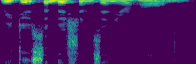

torch.Size([1, 64, 196])

tensor([[[-68.7254, -32.9853, -22.7313,  ..., -79.7596, -80.0000, -79.3097],
         [-79.4191, -39.4489, -29.7642,  ..., -76.4710, -80.0000, -80.0000],
         [-80.0000, -58.8506, -39.1657,  ..., -80.0000, -80.0000, -80.0000],
         ...,
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000],
         [-80.0000, -80.0000, -80.0000,  ..., -80.0000, -80.0000, -80.0000]]])


In [17]:
def test_wav_to_spectro():
    img = wav_to_spectro(wavs[1])
    display(Image(img),img.shape)
    print(img[:10])
test_wav_to_spectro()

In [18]:
data_item = wav_to_spectro(wavs[1])

In [48]:
default_pad = torch.zeros(1, data_item.shape[1], 1) # MUST BE COLUMN shape(1, n_mels, 1)

In [49]:
def chunkify(spectro, col, seq_len=10):
    start = col
    end = col + seq_len
    chunk = spectro[:,:,start:end]
    chunk_len = chunk.shape[2]
    if chunk_len < seq_len:
        num_cols_to_pad = seq_len - chunk_len
        # repeat padded column w: (num_channels, how many times to stack column in y dir, number of columns to add)
        padded = default_pad.clone().repeat(spectro.shape[0], 1, num_cols_to_pad)
        chunk = torch.cat((chunk, padded), 2)
    return chunk    

In [52]:
def test_chunkify():
    max_len = data_item.shape[2]
    c = chunkify(data_item, 0, seq_len=10); assert 10 == c.shape[2]
    c = chunkify(data_item, 5, seq_len=10); assert 10 == c.shape[2]
    c = chunkify(data_item, max_len - 50, seq_len=10)
    c = chunkify(data_item, max_len - 5, seq_len=10)
    print('PASSED')
    
test_chunkify()

PASSED


In [23]:
def sequencify_and_label(spectro, seq_len=10, default_pad=default_pad):
    max_non_pad_len = seq_len//2
    ret = []
    for col in range(0, spectro.shape[2] - max_non_pad_len):
        x = chunkify(spectro, col, seq_len=seq_len)
        y = chunkify(spectro, col + 1, seq_len=seq_len)
        ret.append((x, y))
    return ret

In [66]:
def test_sequencify_and_label(col):
    list_x_and_y = sequencify_and_label(data_item)
    print(len(list_x_and_y))
    tup_x_and_y = list_x_and_y[col]
    display(Image(tup_x_and_y[0]),tup_x_and_y[0].shape)
    display(Image(tup_x_and_y[1]),tup_x_and_y[1].shape)
test_sequencify_and_label(0)
test_sequencify_and_label(190)

191


torch.Size([1, 64, 10])

torch.Size([1, 64, 10])

191


torch.Size([1, 64, 10])

torch.Size([1, 64, 10])